In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import os
import neurokit2 as nk #TODO look into this algorithm
from tqdm import tqdm
import scipy.io
from scipy.sparse import csc_matrix, spdiags
from scipy.sparse.linalg import spsolve

In [2]:
print('finding names of all test files ...')
all_files = []

# for root, dirs, files in os.walk("F:\\DATA\\JSmith_SAFER_20220310\\raw_data\\Feas1\\ECGs"):
#     for file in files:
#         if(file.endswith(".dat")):
#             all_files.append(os.path.join(root,file.split(".dat",2)[0]))
# print('all files found :)')

finding names of all test files ...


In [3]:
indices = np.array([i for i in range(50)])*1000
indices

array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000,
       27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000,
       36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000,
       45000, 46000, 47000, 48000, 49000])

In [4]:
# for test_file in all_files[::1000][:3]:
#     print(test_file)
#     record = wfdb.rdrecord(test_file)
#     entire_ecg_signal = record.p_signal.T[0]
#     plt.plot(entire_ecg_signal[:2000])
#     plt.show()
#     plt.clf()

# Experimenting with baseline_als

Experimenting with different lam "smoothing" parameter, and other paramteres, to take out baseline drift
https://stackoverflow.com/questions/29156532/python-baseline-correction-library

In [5]:
def baseline_als(y, lam=1e6, p=0.01, niter=10):
    L = len(y)
    D = csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in np.arange(niter):
        W = spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [6]:
# for lam_ in np.logspace(2,9):
#     for test_file in all_files[::1000][:1]:
#         print(test_file)
#         record = wfdb.rdrecord(test_file)
#         entire_ecg_signal = record.p_signal.T[0]
#         plt.plot(entire_ecg_signal[:2000] - baseline_als(entire_ecg_signal[:2000], lam=lam_))
#         plt.show()
#         plt.clf()

In [7]:
# for test_file in all_files[::1000][:10]:
#     print(test_file)
#     record = wfdb.rdrecord(test_file)
#     entire_ecg_signal = record.p_signal.T[0]
#     plt.plot(entire_ecg_signal[:2000] - baseline_als(entire_ecg_signal[:2000]))
#     plt.show()
#     plt.clf()

## Experiment with smoothing/ low pass filtering


In [8]:
from scipy.signal import savgol_filter



#### Smoothing method

In [9]:
# for kernel_width in [11,31,51,71,101,201,501]:
#     for test_file in all_files[::1000][:1]:
#         print(test_file, kernel_width)
#         record = wfdb.rdrecord(test_file)
#         entire_ecg_signal = record.p_signal.T[0]
#         signal_no_wander = entire_ecg_signal - baseline_als(entire_ecg_signal)
#         signal_smoothed = savgol_filter(signal_no_wander, kernel_width, 3)
#         plt.plot(signal_smoothed[:2000])
#         plt.show()
#         plt.clf()


Idea, potentially train the smoothing parameters to each patient by adjusting to least likely to show "~" prediction.

#### LPF method

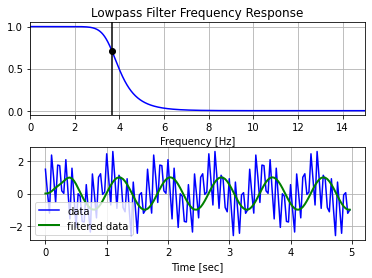

In [10]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, fs=fs, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(w, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

In [11]:
# for cutoff_ in np.logspace(-1,1, num=20):
#     for test_file in all_files[::1000][:1]:
#         print(test_file, cutoff_)
#         record = wfdb.rdrecord(test_file)
#         entire_ecg_signal = record.p_signal.T[0]
#         signal_no_wander = entire_ecg_signal - baseline_als(entire_ecg_signal)
#         signal_smoothed = butter_lowpass_filter(signal_no_wander, cutoff_, fs, order)
#         plt.plot(signal_smoothed[:2000])
#         plt.show()
#         plt.clf()

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


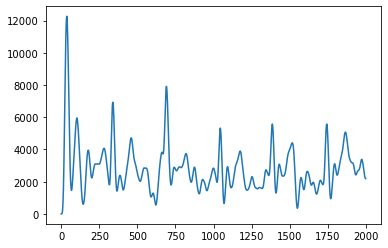

D:\OneDrive - University of Cambridge\11B\Project\2_data\physionet_datasets\training2017\A00002


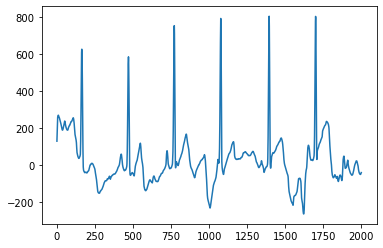

<Figure size 432x288 with 0 Axes>

In [15]:
test_file_SAFER = "F:\DATA\\JSmith_SAFER_20220310\\raw_data\\Feas1\\ECGs\\000000\\saferF1_000001"
test_file_2017 = "D:\\OneDrive - University of Cambridge\\11B\\Project\\2_data\\physionet_datasets\\training2017\\A00002"




print(test_file_SAFER)
record = wfdb.rdrecord(test_file_SAFER)
ecg_SAFER = record.p_signal.T[0]
signal_no_wander = ecg_SAFER - baseline_als(ecg_SAFER)
signal_smoothed = butter_lowpass_filter(signal_no_wander, 0.7, 30)
plt.plot(signal_smoothed[:2000])
plt.show()
plt.clf()

print(test_file_2017)
ecg_2017 = scipy.io.loadmat(test_file_2017)['val'][0]
plt.plot(ecg_2017[:2000])
plt.show()
plt.clf()

# Save preprocessed data

In [ ]:
# import shutil

In [ ]:
# for test_file in all_files[::1000][:10]:
#     #preprocess
#     record = wfdb.rdrecord(test_file)
#     ecg_signal = record.p_signal.T[0]
#     signal_no_wander = ecg_signal - baseline_als(ecg_signal)
#     signal_smoothed = butter_lowpass_filter(signal_no_wander, 0.7, fs, order)
#     plt.plot(signal_smoothed)
#     plt.show()
#     plt.clf()
#     #save this file
#     filename = test_file.split("\\")[-1]
#     dat_path = f"F:\\DATA\\JSmith_SAFER_20220310\\preprocessed_data\\{filename}.dat"
#     np.savetxt(dat_path, signal_smoothed)
#     #copy over .hea file
#     shutil.copyfile(test_file + ".hea", dat_path.replace(".dat", ".hea"))
#     print(filename)

In [ ]:
# record = wfdb.rdrecord("F:\DATA\JSmith_SAFER_20220310\preprocessed_data\saferF1_000001")
# entire_ecg_signal = record.p_signal.T[0]
# plt.plot(entire_ecg_signal)
# plt.show()
# plt.clf()